In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

sample_submission.csv
sample_submission_stg2.csv
test.tsv
test_stg2.tsv
train.tsv



In [2]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [3]:
#LOAD DATA
print("Loading data...")
train_data = pd.read_table("../input/train.tsv")
test_data = pd.read_table("../input/test_stg2.tsv")
print(train_data.shape)
print(test_data.shape)

Loading data...
(1482535, 8)
(3460725, 7)


In [4]:
%%time
# attempt to find missing brand names

train_data.brand_name.fillna(value="missing", inplace=True)
test_data.brand_name.fillna(value="missing", inplace=True)

unique_brand_names = set(train_data.brand_name.unique()).union(set(test_data.brand_name.unique()))

# get to finding!
premissing = len(train_data.loc[train_data['brand_name'] == 'missing'])
def brandfinder(line):
    brand = line[0]
    name = line[1]
    if brand == 'missing':
        for brand_name in unique_brand_names:
            if brand_name in name and len(brand_name)>2:
                return brand_name
    return brand

CPU times: user 768 ms, sys: 20 ms, total: 788 ms
Wall time: 790 ms


In [5]:
%%time
train_data['brand_name'] = train_data[['brand_name','name']].apply(brandfinder, axis = 1)
test_data['brand_name'] = test_data[['brand_name','name']].apply(brandfinder, axis = 1)
found = premissing-len(train_data.loc[train_data['brand_name'] == 'missing'])
print(found)


203072
CPU times: user 21min 55s, sys: 652 ms, total: 21min 56s
Wall time: 21min 56s


In [6]:
#HANDLE MISSING VALUES
print("Handling missing values...")
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train_data = handle_missing(train_data)
test_data = handle_missing(test_data)
print(train_data.shape)
print(test_data.shape)

Handling missing values...
(1482535, 8)
(3460725, 7)


In [7]:
train_data.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [8]:
#PROCESS CATEGORICAL DATA
print("Handling categorical variables...")
le = LabelEncoder()

le.fit(np.hstack([train_data.category_name, test_data.category_name]))
train_data.category_name = le.transform(train_data.category_name)
test_data.category_name = le.transform(test_data.category_name)

le.fit(np.hstack([train_data.brand_name, test_data.brand_name]))
train_data.brand_name = le.transform(train_data.brand_name)
test_data.brand_name = le.transform(test_data.brand_name)
del le

train_data.head(3)


Handling categorical variables...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,864,3514,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,87,4660,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1320,5489,10.0,1,Adorable top with a hint of lace and a key hol...


In [9]:
#PROCESS TEXT: RAW
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train_data.item_description.str.lower(), train_data.name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")

train_data["seq_item_description"] = tok_raw.texts_to_sequences(train_data.item_description.str.lower())
test_data["seq_item_description"] = tok_raw.texts_to_sequences(test_data.item_description.str.lower())
train_data["seq_name"] = tok_raw.texts_to_sequences(train_data.name.str.lower())
test_data["seq_name"] = tok_raw.texts_to_sequences(test_data.name.str.lower())
train_data.head(3)

Text to seq process...


Using TensorFlow backend.


   Fitting tokenizer...
   Transforming text to seq...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,864,3514,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,87,4660,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1320,5489,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


In [10]:
#SEQUENCES VARIABLES ANALYSIS
max_name_seq = np.max([np.max(train_data.seq_name.apply(lambda x: len(x))), np.max(test_data.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train_data.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test_data.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


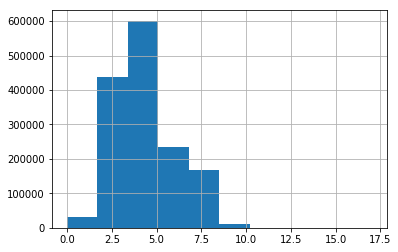

In [11]:
train_data.seq_name.apply(lambda x: len(x)).hist()

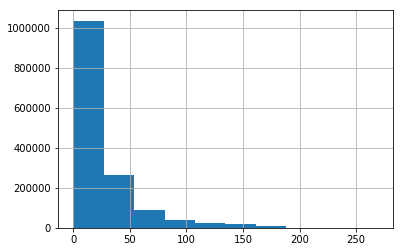

In [12]:
train_data.seq_item_description.apply(lambda x: len(x)).hist()

In [13]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train_data.seq_name.max())
                   , np.max(test_data.seq_name.max())
                  , np.max(train_data.seq_item_description.max())
                  , np.max(test_data.seq_item_description.max())])+2
MAX_CATEGORY = np.max([train_data.category_name.max(), test_data.category_name.max()])+1
MAX_BRAND = np.max([train_data.brand_name.max(), test_data.brand_name.max()])+1
MAX_CONDITION = np.max([train_data.item_condition_id.max(), test_data.item_condition_id.max()])+1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80ba80df28>]],
      dtype=object)

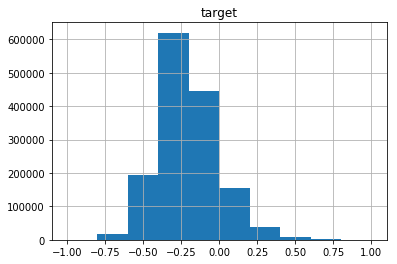

In [14]:
#SCALE target variable
train_data["target"] = np.log(train_data.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train_data["target"] = target_scaler.fit_transform(np.array(train_data.target).reshape(-1,1))
pd.DataFrame(train_data.target).hist()

In [15]:
#EXTRACT DEVELOPTMENT TEST
dtrain, dvalid = train_test_split(train_data, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1467709, 11)
(14826, 11)


In [16]:
#KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name)
        ,'category_name': np.array(dataset.category_name)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test_data)

In [17]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()
    


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
category_name (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
item_desc (InputLayer

In [18]:
from keras.utils import plot_model
plot_model(model)

In [19]:
#FITTING THE MODEL
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 1467709 samples, validate on 14826 samples
Epoch 1/5
1467709/1467709 [==============================] - 24s 17us/step - loss: 0.0315 - mean_absolute_error: 0.1342 - rmsle_cust: 0.0162 - val_loss: 0.0184 - val_mean_absolute_error: 0.1030 - val_rmsle_cust: 0.0136
Epoch 2/5
1467709/1467709 [==============================] - 20s 14us/step - loss: 0.0188 - mean_absolute_error: 0.1041 - rmsle_cust: 0.0134 - val_loss: 0.0165 - val_mean_absolute_error: 0.0971 - val_rmsle_cust: 0.0129
Epoch 3/5
1467709/1467709 [==============================] - 20s 14us/step - loss: 0.0165 - mean_absolute_error: 0.0975 - rmsle_cust: 0.0127 - val_loss: 0.0156 - val_mean_absolute_error: 0.0951 - val_rmsle_cust: 0.0125
Epoch 4/5
1467709/1467709 [==============================] - 20s 14us/step - loss: 0.0152 - mean_absolute_error: 0.0932 - rmsle_cust: 0.0122 - val_loss: 0.0153 - val_mean_absolute_error: 0.0940 - val_rmsle_cust: 0.0124
Epoch 5/5
1467709/146770

In [20]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.48198120488385143


In [21]:
#CREATE PREDICTIONS
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test_data[["test_id"]]
submission["price"] = preds

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


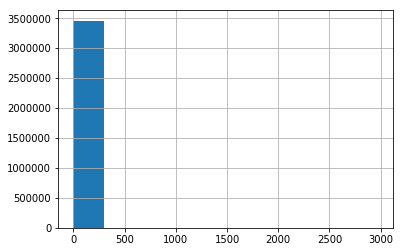

In [22]:
submission.to_csv("./simple_keras.csv", index=False)
submission.price.hist()